In [2]:
import pandas as pd

folds = [pd.read_csv(f"data/fold_{i}.csv") for i in range(5)]

test = pd.read_csv("data/test.csv")

In [3]:
data = folds[0].copy()

for i in range(1, 5):
    data = pd.concat([data, folds[i]])

In [6]:
for fold in folds:
    print(fold.shape)

print(data.shape)
print(test.shape)

(735331, 3)
(734143, 3)
(736045, 3)
(738197, 3)
(735689, 3)
(3679405, 3)
(946141, 3)


Task list:

Data analysis:
- Explore the data all together
  - Analyze peptide column (length distribution, what characters)
  - Analyze allele column (understand naming convention, distribution, find a proper representation)
  - Analyze label distribution (distribution)

- Explore folds distribution
- Explore test data distribution



In [7]:
data.head()

,peptide,allele,hit
0,YFPLAPFNQL,HLA-C*14:02,1
1,KESKINQVF,HLA-B*44:02,1
2,QPHDPLVPLSA,HLA-B*54:01,1
3,RTIADSLINSF,HLA-B*57:03,1
4,EEKTIIKKL,HLA-B*44:03,1


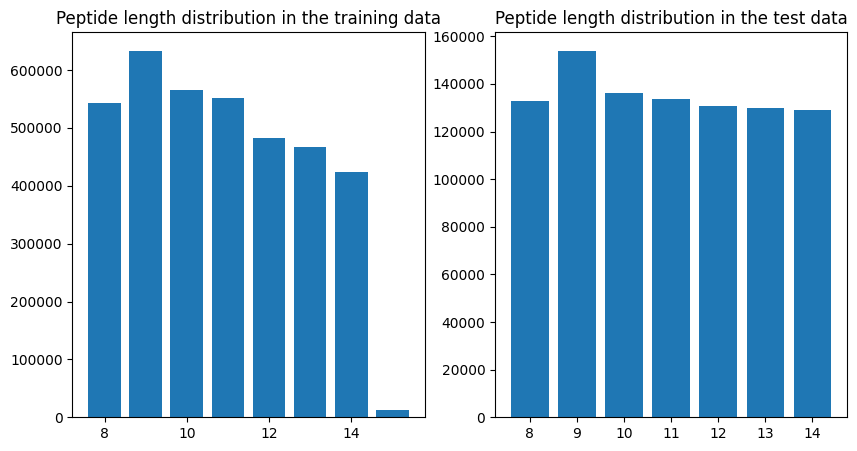

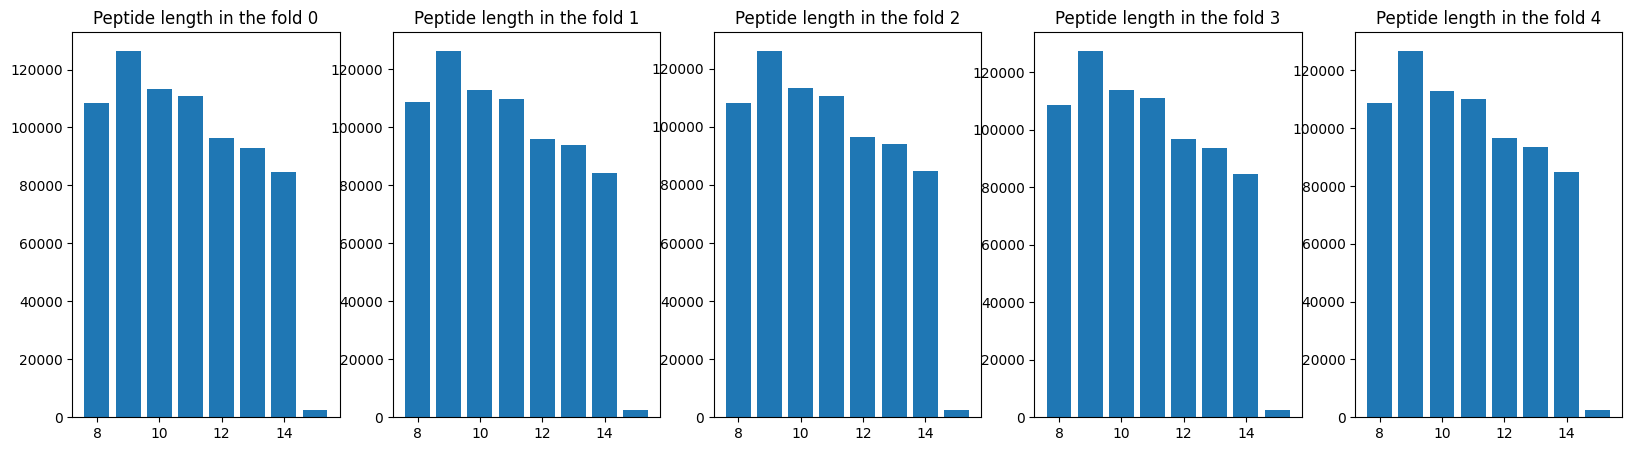

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.subplots(1, 2, figsize=(10, 5))

plt.subplot(1, 2, 1)
unique, counts = np.unique(data["peptide"].apply(len), return_counts=True)
plt.bar(unique, counts)
plt.title("Peptide length distribution in the training data")

plt.subplot(1, 2, 2)
unique, counts = np.unique(test["peptide"].apply(len), return_counts=True)
plt.bar(unique, counts)
plt.title("Peptide length distribution in the test data")
plt.show()

plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    unique, counts = np.unique(folds[i]["peptide"].apply(len), return_counts=True)
    plt.bar(unique, counts)
    plt.title(f"Peptide length in the fold {i}")

plt.show()

In the train set, the peptides are sequences of amino acids of length 8 - 14 with only very few samples of length 15. The length distribution is rather balanced in 8 - 14. The distribution of length is pretty similar in the test set and there is no sequence of 15 amino acids so there will not be any issues of out-of-distribution peptide length. As only 0.3 % of the samples are of length 15, we can safely keep them without any special treatment.

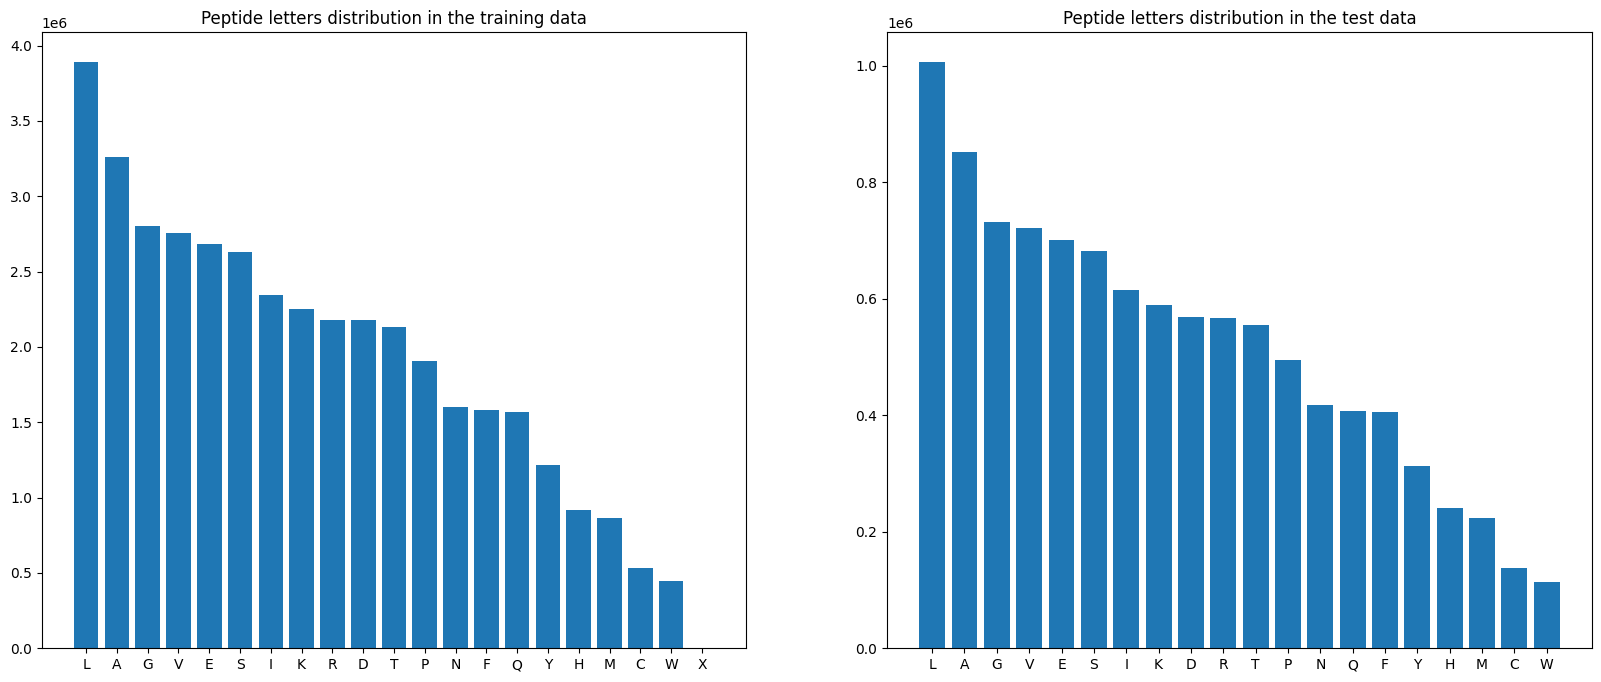

In [49]:
plt.subplots(figsize=(20, 8))

train_letters_count = {}

for peptide in data["peptide"]:
    for letter in peptide:
        train_letters_count[letter] = train_letters_count.get(letter, 0) + 1

sorted_keys = sorted(
    train_letters_count, key=lambda x: train_letters_count[x], reverse=True
)
sorted_values = [train_letters_count[key] for key in sorted_keys]

plt.axis("off")

plt.subplot(1, 2, 1)
plt.bar(sorted_keys, sorted_values)
# plt.yscale("log")
plt.title("Peptide letters distribution in the training data")

test_letters_count = {}

for peptide in test["peptide"]:
    for letter in peptide:
        test_letters_count[letter] = test_letters_count.get(letter, 0) + 1

sorted_keys = sorted(
    test_letters_count, key=lambda x: test_letters_count[x], reverse=True
)

sorted_values = [test_letters_count[key] for key in sorted_keys]

plt.subplot(1, 2, 2)
plt.bar(sorted_keys, sorted_values)
# plt.yscale("log")
plt.title("Peptide letters distribution in the test data")
plt.show()

The amino acids are represented by the 21 letters of the alphabet. Only The distribution of the amino acids is similar in the train and test set. The amino acids are not distributed uniformly, but not too skewed either. The 'X' amino acid is only present in the train set and it is so rare that we can either drop it or keep it without changing the results.

Hit ratio in train set: 0.05368993084479692
Hit ratio in test set 0.04800130213150049


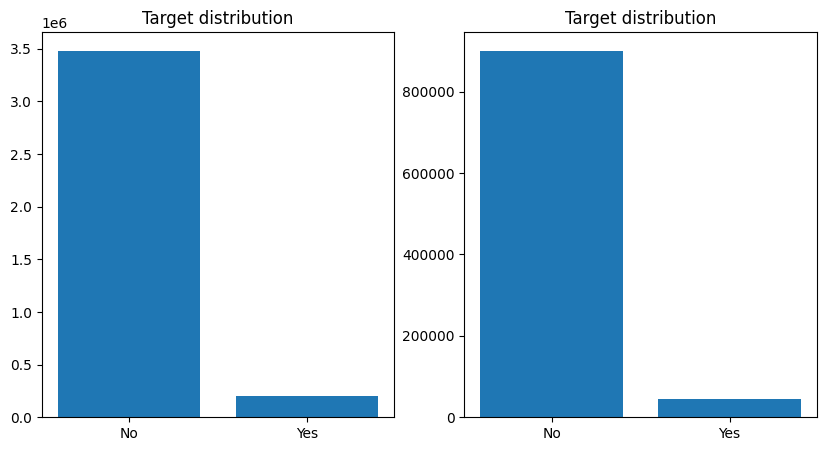

In [61]:
plt.subplots(figsize=(10, 5))
plt.axis("off")

plt.subplot(1, 2, 1)
values, counts = np.unique(data["hit"], return_counts=True)

plt.bar(values, counts)
plt.xticks(values, ["No", "Yes"])
plt.title("Target distribution")

print("Hit ratio in train set:", data["hit"].sum() / data.shape[0])


plt.subplot(1, 2, 2)

values, counts = np.unique(test["hit"], return_counts=True)

plt.bar(values, counts)
plt.xticks(values, ["No", "Yes"])
plt.title("Target distribution")

print("Hit ratio in test set", test["hit"].sum() / test.shape[0])

plt.show()

The ratio of hits in the train set and in the test set is around 5%. The distribution of hits is similar in the train and test set so we can expect the test set to be a good representative of the train set. The unbalanced distribution of hits will be a challenge for the model and we will have to use a metric that is robust to unbalanced classes such as the F1 score, precision and recall. An interesting question is what is important in our application: is it precision, recall, or both?

In [11]:
pd.set_option("display.max_rows", 500)

print(data["peptide"].value_counts().head(10))
sum_count = data.groupby("peptide").agg({"hit": ["sum", "count"]})
sum_count = sum_count["hit"].sort_values("count", ascending=False)  # type: ignore
print(
    sum_count[(sum_count["sum"] != sum_count["count"]) & (sum_count["sum"] != 0)].head(
        10
    )
)



print(test["peptide"].value_counts().head(10))



sum_count = test.groupby("peptide").agg({"hit": ["sum", "count"]})
sum_count = sum_count["hit"].sort_values("count", ascending=False)  # type: ignore
print(
    sum_count[(sum_count["sum"] != sum_count["count"]) & (sum_count["sum"] != 0)].head(
        10
    )
)

peptide
NNNNNNNNN        34
NNNNNNNNNN       31
NNNNNNNN         29
NNNNNNNNNNN      27
QQQQQQQQQ        26
NNNNNNNNNNNNN    26
QQQQQQQQ         24
QQQQQQQQQQ       22
QQQQQQQQQQQ      22
NNNNNNNNNNNN     21
Name: count, dtype: int64
Empty DataFrame
Columns: [sum, count]
Index: []
peptide
TFTVTEKPEVID      36
IAPTGHSL          35
HLPETKFSEL        35
TLKGETTTEAVD      34
TKTFTVTEKPEVID    34
NAPWAVTSL         34
TVTEKPEVID        32
SVPEAQSAL         32
SIPEKNRPL         31
ISPTGHSL          31
Name: count, dtype: int64
             sum  count
peptide                
LRVDPVNFK      5      8
FAYDGKDYI      7      8
AVFPSIVGRPR    5      6
AVEAKKTYVRD    5      6
RVAPEEHPVLL    3      4
DLTDYLMK       3      4
RIIPRHLQL      3      4
IREEYPDR       3      4
LLVVYPWTQR     3      4
TLSDYNIQK      3      4


The previous cell shows some peptides are present with different allele versions. In the train set, all allele versions have the same label while in the test set, some allele versions have different labels. This means that the allele version is important for the prediction. 

In [14]:
print(data["allele"].value_counts())

test["allele"].value_counts()

allele
HLA-A*02:01    265252
HLA-B*07:02    201038
HLA-B*57:01    184773
HLA-A*29:02    181136
HLA-B*40:02    145817
HLA-B*15:01    145365
HLA-A*24:02    118743
HLA-A*02:07    107169
HLA-B*27:05    102116
HLA-C*05:01     95874
HLA-B*27:09     93384
HLA-B*08:01     86437
HLA-A*01:01     84823
HLA-A*02:04     84438
HLA-A*03:01     80196
HLA-B*44:03     79392
HLA-B*44:02     79200
HLA-B*57:03     76422
HLA-B*51:01     75169
HLA-B*58:01     65852
HLA-B*27:01     62976
HLA-C*03:04     59096
HLA-C*06:02     57238
HLA-A*11:01     53824
HLA-B*40:01     49883
HLA-B*27:02     48541
HLA-B*15:02     47965
HLA-C*08:02     47930
HLA-B*46:01     47700
HLA-C*04:01     46055
HLA-A*02:03     44413
HLA-C*16:01     42603
HLA-C*01:02     41465
HLA-B*35:01     41239
HLA-B*27:07     41149
HLA-A*68:02     38139
HLA-B*27:08     35916
HLA-C*14:02     34465
HLA-C*15:02     34047
HLA-C*02:02     31874
HLA-C*03:03     31071
HLA-C*07:02     28836
HLA-B*27:04     28515
HLA-B*27:06     27663
HLA-A*31:01     27539
HLA

allele
HLA-A02:02    77053
HLA-A02:06    54510
HLA-A02:11    48445
HLA-B53:01    46991
HLA-B15:17    45917
HLA-A02:05    45136
HLA-B15:03    44968
HLA-A33:01    43333
HLA-A66:01    41538
HLA-C12:03    36448
HLA-C03:03    35568
HLA-A11:01    33424
HLA-A30:02    33180
HLA-C08:02    32416
HLA-A23:01    30467
HLA-A32:01    28036
HLA-B40:02    23768
HLA-B14:02    21601
HLA-B37:01    20048
HLA-B40:01    18908
HLA-B45:01    18750
HLA-B18:01    18284
HLA-B58:01    17946
HLA-B15:02    16702
HLA-B15:01    16624
HLA-A30:01    15837
HLA-C07:02    15293
HLA-B46:01    14015
HLA-B38:01     9509
HLA-B35:03     8275
HLA-A26:01     7730
HLA-C05:01     7033
HLA-A25:01     6906
HLA-A68:01     5648
HLA-B08:01     3365
HLA-B07:02     2469
Name: count, dtype: int64

In [24]:
data["allele_gene"] = data["allele"].apply(lambda x: x[4])
data["allele_group"] = data["allele"].apply(lambda x: x[6:8])
data["allele_prot"] = data["allele"].apply(lambda x: x[9:])

test["allele_gene"] = test["allele"].apply(lambda x: x[4])
test["allele_group"] = test["allele"].apply(lambda x: x[5:7])
test["allele_prot"] = test["allele"].apply(lambda x: x[8:])

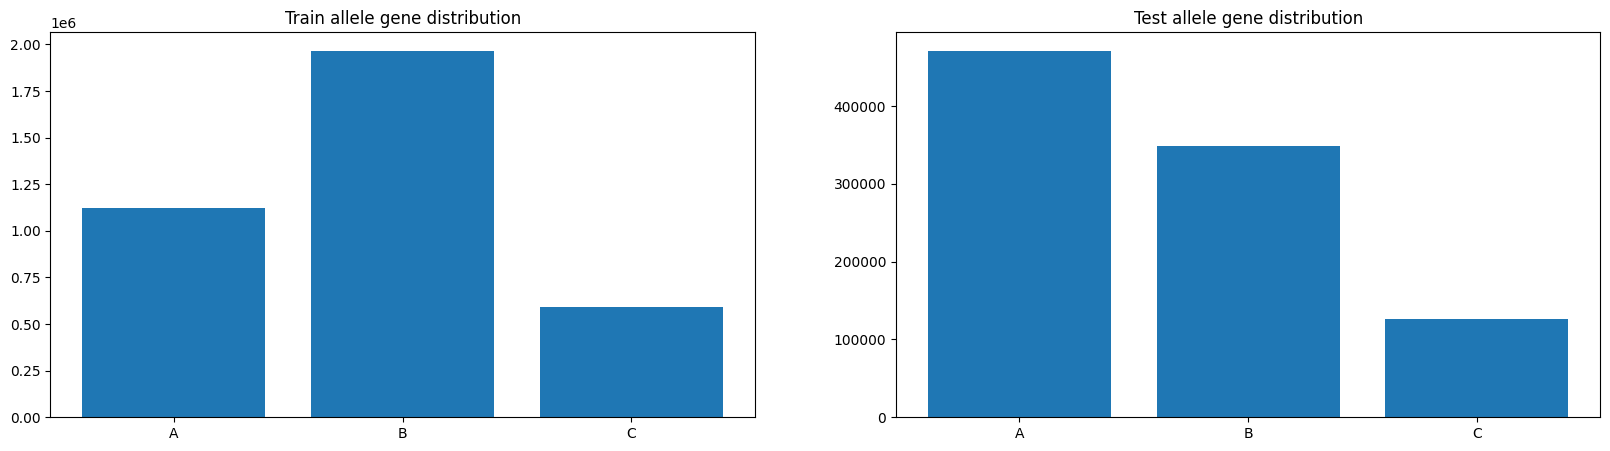

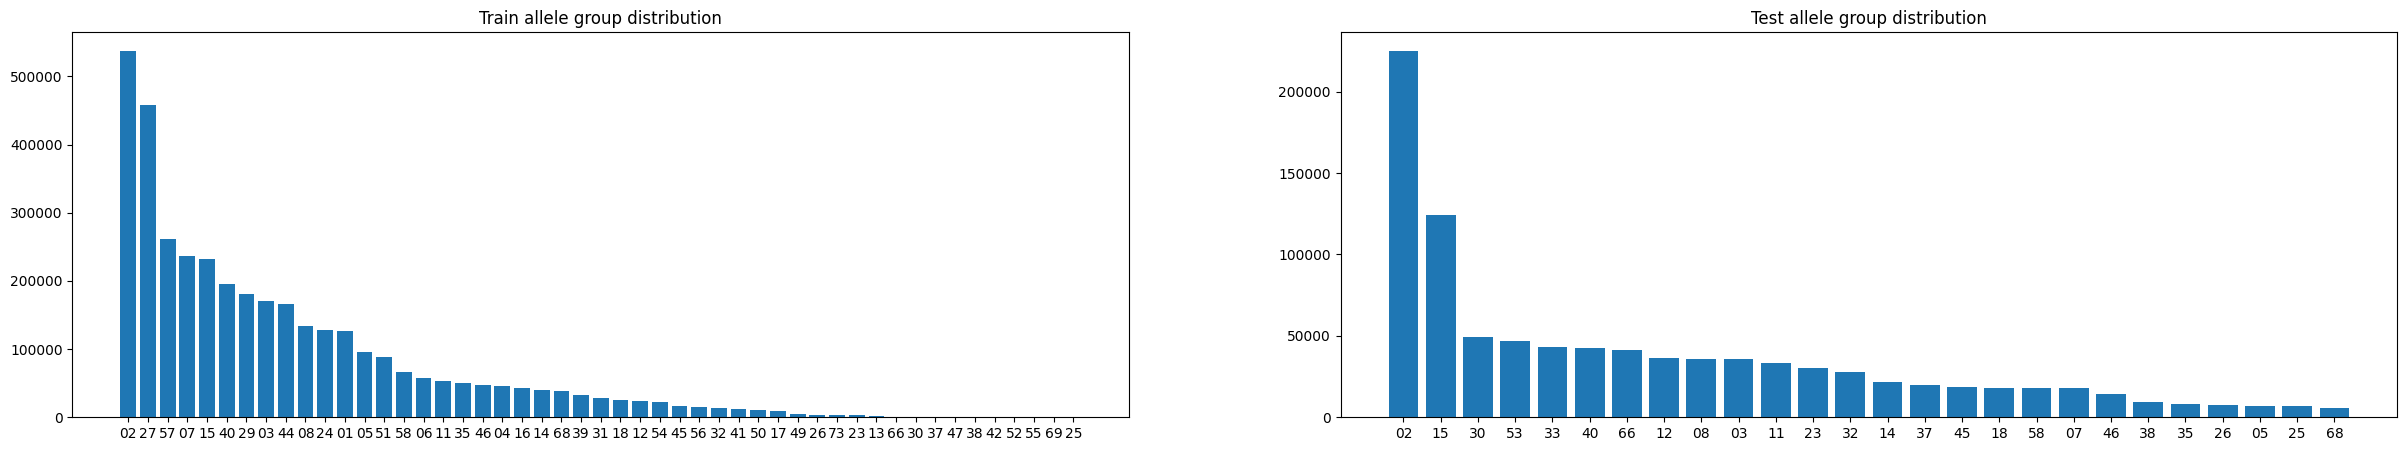

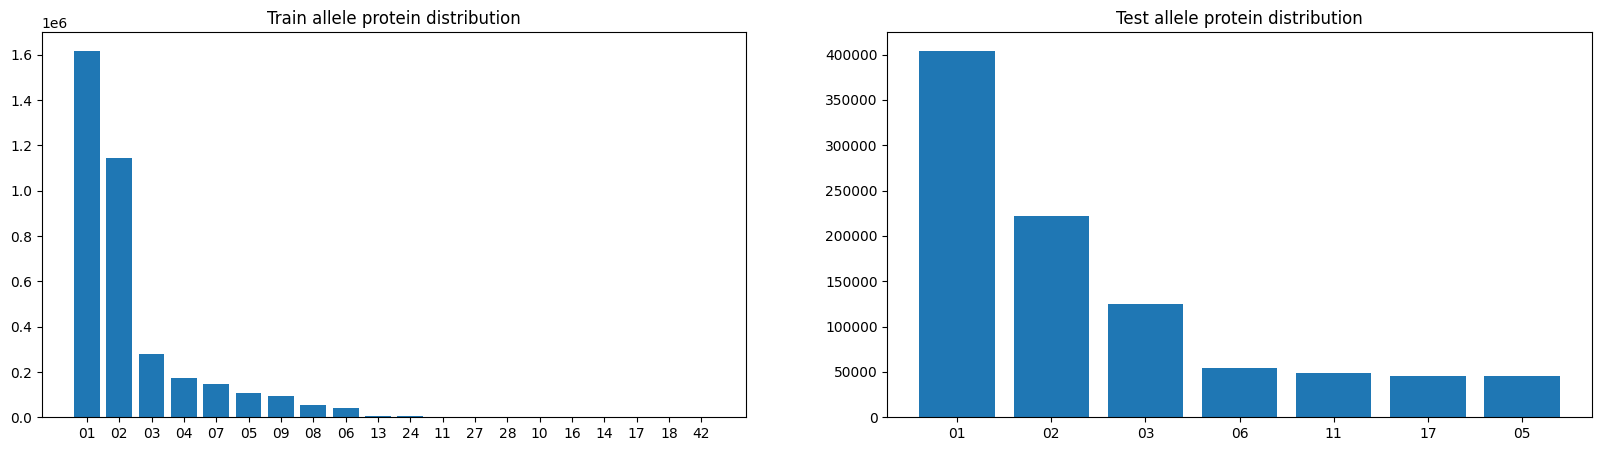

In [30]:
plt.subplots(1, 2, figsize=(20, 5))

plt.subplot(1, 2, 1)
values, counts = np.unique(data["allele_gene"], return_counts=True)

plt.bar(values, counts)
plt.title("Train allele gene distribution")

plt.subplot(1, 2, 2)

values, counts = np.unique(test["allele_gene"], return_counts=True)
sorted_arg = np.argsort(counts)[::-1]
values = values[sorted_arg]
counts = counts[sorted_arg]


plt.bar(values, counts)
plt.title("Test allele gene distribution")

plt.show()


plt.subplots(1, 2, figsize=(30, 5))

plt.subplot(1, 2, 1)
values, counts = np.unique(data["allele_group"], return_counts=True)
sorted_arg = np.argsort(counts)[::-1]
values = values[sorted_arg]
counts = counts[sorted_arg]


plt.bar(values, counts)
plt.title("Train allele group distribution")

plt.subplot(1, 2, 2)

values, counts = np.unique(test["allele_group"], return_counts=True)
sorted_arg = np.argsort(counts)[::-1]
values = values[sorted_arg]
counts = counts[sorted_arg]


plt.bar(values, counts)
plt.title("Test allele group distribution")

plt.show()


plt.subplots(1, 2, figsize=(20, 5))

plt.subplot(1, 2, 1)
values, counts = np.unique(data["allele_prot"], return_counts=True)
sorted_arg = np.argsort(counts)[::-1]
values = values[sorted_arg]
counts = counts[sorted_arg]

plt.bar(values, counts)
plt.title("Train allele protein distribution")

plt.subplot(1, 2, 2)

values, counts = np.unique(test["allele_prot"], return_counts=True)
sorted_arg = np.argsort(counts)[::-1]
values = values[sorted_arg]
counts = counts[sorted_arg]

plt.bar(values, counts)
plt.title("Test allele protein distribution")

plt.show()

The difference in distribution of allele versions between the train and test set is not too big suggests that we should probably not depend too much on the allele version.